In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import multivariate_normal as mvn
import math

from numpy.linalg import slogdet, det, solve
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import time

from sklearn.datasets import load_digits
from sklearn.mixture.base import BaseMixture
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import os, sys, email,re
from nltk.corpus import stopwords
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['enron-email-dataset', 'samples']


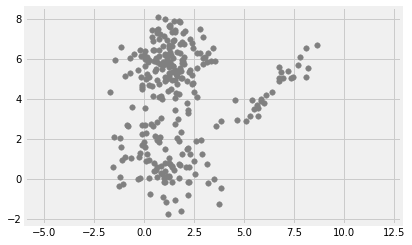

[0.3451814  0.6066179  0.04820071] [[-0.71336192  0.90635089]
 [ 0.76623673  0.82605407]
 [-1.32368279 -1.75244452]]


In [2]:
samples = np.load('../input/samples/samples.npz')
X = samples['data']
pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='grey', s=30)
plt.axis('equal')
plt.show()
print(pi0, mu0)

# GMM should produce something similar

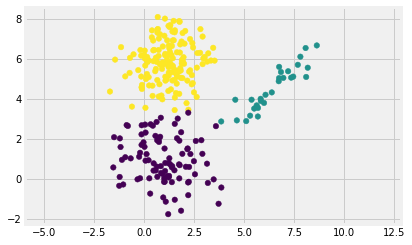

array([[0.9733235 , 0.94371856],
       [6.40546402, 4.50975916],
       [1.20514208, 5.82885457]])

In [3]:
kmeans_test = KMeans(n_clusters= 3, init="k-means++", max_iter=500, algorithm = 'auto')
fitted = kmeans_test.fit(X)
prediction = kmeans_test.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=prediction, s=30)
plt.axis('equal')
plt.show()

kmeans_test.cluster_centers_

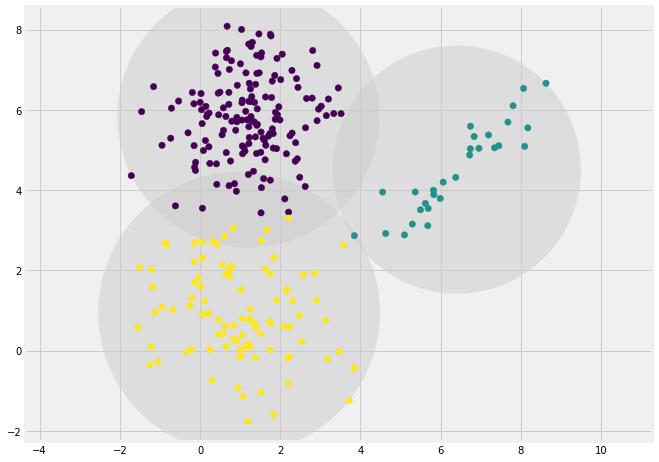

In [4]:
plt.figure(figsize = (10,8))
from scipy.spatial.distance import cdist
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
plot_kmeans(kmeans_test, X)

# GMM sklearn

[[1.    0.    0.   ]
 [0.999 0.    0.001]
 [0.999 0.    0.001]
 [1.    0.    0.   ]
 [1.    0.    0.   ]]


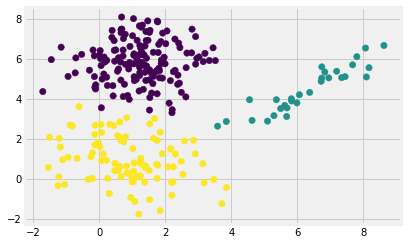

In [5]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

In [6]:
print(gmm._get_parameters()[0])
print(gmm._get_parameters()[1])
#gmm.lower_bound_
# kmeans mean values
# array([[1.20514208, 5.82885457],
#        [0.9733235 , 0.94371856],
#        [6.40546402, 4.50975916]])

[0.55100617 0.10685277 0.34214106]
[[1.2215991  5.82962808]
 [6.30978007 4.44084974]
 [0.92634336 0.96642033]]


# Test Functions from class

In [7]:
def calculate_mean_covariance(X, prediction):
    C = 3
    d = X.shape[1]
    labels = np.unique(prediction)
    initial_means = np.zeros((C, d))
    initial_cov = np.zeros((C, d, d))
    initial_pi = np.zeros(C)
        
    counter=0
    for label in sorted(labels):
        ids = np.where(prediction == label) # returns indices
        initial_pi[counter] = len(ids[0]) / X.shape[0] 
        initial_means[counter,:] = np.mean(X[ids], axis = 0)
        de_meaned = X[ids] - initial_means[counter,:]
        Nk = X[ids].shape[0]
        initial_cov[counter,:, :] = np.dot(initial_pi[counter] * de_meaned.T, de_meaned) / Nk
        counter+=1
    assert np.sum(initial_pi) == 1
    return (initial_means, initial_cov, initial_pi)
    
n_clusters = 3
kmeans = KMeans(n_clusters= n_clusters, max_iter=500, algorithm = 'auto')
fitted = kmeans.fit(X)
prediction = kmeans.predict(X)

m, c, pi = calculate_mean_covariance(X, prediction)

# New E-Step

In [8]:
class GMM:
    """ Gaussian Mixture Model
    
    Parameters
    -----------
        k: int , number of gaussian distributions
        
        seed: int, will be randomly set if None
        
        max_iter: int, number of iterations to run algorithm, default: 200
        
    Attributes
    -----------
       centroids: array, k, number_features
       
       cluster_labels: label for each data point
       
    """
    def __init__(self, C, n_runs):
        self.C = C # number of Guassians/clusters
        self.n_runs = n_runs
        
    
    def get_params(self):
        return (self.mu, self.pi, self.sigma)
    
    
        
    def calculate_mean_covariance(self, X, prediction):
        """Calculate means and covariance of different
            clusters from k-means prediction
        
        Parameters:
        ------------
        prediction: cluster labels from k-means
        
        X: N*d numpy array data points 
        
        Returns:
        -------------
        intial_means: for E-step of EM algorithm
        
        intial_cov: for E-step of EM algorithm
        
        """
        d = X.shape[1]
        labels = np.unique(prediction)
        self.initial_means = np.zeros((self.C, d))
        self.initial_cov = np.zeros((self.C, d, d))
        self.initial_pi = np.zeros(self.C)
        
        counter=0
        for label in labels:
            ids = np.where(prediction == label) # returns indices
            self.initial_pi[counter] = len(ids[0]) / X.shape[0]
            self.initial_means[counter,:] = np.mean(X[ids], axis = 0)
            de_meaned = X[ids] - self.initial_means[counter,:]
            Nk = X[ids].shape[0] # number of data points in current gaussian
            self.initial_cov[counter,:, :] = np.dot(self.initial_pi[counter] * de_meaned.T, de_meaned) / Nk
            counter+=1
        assert np.sum(self.initial_pi) == 1    
            
        return (self.initial_means, self.initial_cov, self.initial_pi)
    
    
    
    def _initialise_parameters(self, X):
        """Implement k-means to find starting
            parameter values.
            https://datascience.stackexchange.com/questions/11487/how-do-i-obtain-the-weight-and-variance-of-a-k-means-cluster

        Parameters:
        ------------
        X: numpy array of data points
        
        Returns:
        ----------
        tuple containing initial means and covariance
        
        _initial_means: numpy array: (C*d)
        
        _initial_cov: numpy array: (C,d*d)
        
        
        """
        n_clusters = self.C
        kmeans = KMeans(n_clusters= n_clusters, init="k-means++", max_iter=500, algorithm = 'auto')
        fitted = kmeans.fit(X)
        prediction = kmeans.predict(X)
        self._initial_means, self._initial_cov, self._initial_pi = self.calculate_mean_covariance(X, prediction)
        
        
        return (self._initial_means, self._initial_cov, self._initial_pi)
            
        
        
    def _e_step(self, X, pi, mu, sigma):
        """Performs E-step on GMM model

        Parameters:
        ------------
        X: (N x d), data points, m: no of features
        pi: (C), weights of mixture components
        mu: (C x d), mixture component means
        sigma: (C x d x d), mixture component covariance matrices

        Returns:
        ----------
        gamma: (N x C), probabilities of clusters for objects
        """
        N = X.shape[0] 
        self.gamma = np.zeros((N, self.C))

        const_c = np.zeros(self.C)
        
        
        self.mu = mu if self._initial_means is None else self._initial_means
        self.pi = pi if self._initial_pi is None else self._initial_pi
        self.sigma = sigma if self._initial_cov is None else self._initial_cov

        for c in range(self.C):
            # Posterior Distribution using Bayes Rule
            self.gamma[:,c] = self.pi[c] * mvn.pdf(X, self.mu[c,:], self.sigma[c])

        # normalize across columns to make a valid probability
        gamma_norm = np.sum(self.gamma, axis=1)[:,np.newaxis]
        self.gamma /= gamma_norm

        return self.gamma
    
    
    def _m_step(self, X, gamma):
        """Performs M-step of the GMM
        We need to update our priors, our means
        and our covariance matrix.

        Parameters:
        -----------
        X: (N x d), data 
        gamma: (N x C), posterior distribution of lower bound 

        Returns:
        ---------
        pi: (C)
        mu: (C x d)
        sigma: (C x d x d)
        """
        N = X.shape[0] # number of objects
        C = self.gamma.shape[1] # number of clusters
        d = X.shape[1] # dimension of each object

        # responsibilities for each gaussian
        self.pi = np.mean(self.gamma, axis = 0)

        self.mu = np.dot(self.gamma.T, X) / np.sum(self.gamma, axis = 0)[:,np.newaxis]

        for c in range(C):
            x = X - self.mu[c, :] # (N x d)
            
            gamma_diag = np.diag(self.gamma[:,c])
            x_mu = np.matrix(x)
            gamma_diag = np.matrix(gamma_diag)

            sigma_c = x.T * gamma_diag * x
            self.sigma[c,:,:]=(sigma_c) / np.sum(self.gamma, axis = 0)[:,np.newaxis][c]

        return self.pi, self.mu, self.sigma
    
    
    def _compute_loss_function(self, X, pi, mu, sigma):
        """Computes lower bound loss function
        
        Parameters:
        -----------
        X: (N x d), data 
        
        Returns:
        ---------
        pi: (C)
        mu: (C x d)
        sigma: (C x d x d)
        """
        N = X.shape[0]
        C = self.gamma.shape[1]
        self.loss = np.zeros((N, C))

        for c in range(C):
            dist = mvn(self.mu[c], self.sigma[c],allow_singular=True)
            self.loss[:,c] = self.gamma[:,c] * (np.log(self.pi[c]+0.00001)+dist.logpdf(X)-np.log(self.gamma[:,c]+0.000001))
        self.loss = np.sum(self.loss)
        return self.loss
    
    
    
    def fit(self, X):
        """Compute the E-step and M-step and
            Calculates the lowerbound
        
        Parameters:
        -----------
        X: (N x d), data 
        
        Returns:
        ----------
        instance of GMM
        
        """
        
        d = X.shape[1]
        mu, sigma, pi =  self._initialise_parameters(X)
        
        try:
            for run in range(self.n_runs):  
                self.gamma  = self._e_step(X, mu, pi, sigma)
                pi, mu, sigma = self._m_step(X, self.gamma)
                loss = self._compute_loss_function(X, pi, mu, sigma)
                
                if run % 10 == 0:
                    print("Iteration: %d Loss: %0.6f" %(run, loss))

        
        except Exception as e:
            print(e)
            
        
        return self
    
    
    
    
    def predict(self, X):
        """Returns predicted labels using Bayes Rule to
        Calculate the posterior distribution
        
        Parameters:
        -------------
        X: ?*d numpy array
        
        Returns:
        ----------
        labels: predicted cluster based on 
        highest responsibility gamma.
        
        """
        labels = np.zeros((X.shape[0], self.C))
        
        for c in range(self.C):
            labels [:,c] = model.pi[c] * mvn.pdf(X, model.mu[c,:], model.sigma[c])
        labels  = labels .argmax(1)
        return labels 
    
    def predict_proba(self, X):
        """Returns predicted labels
        
        Parameters:
        -------------
        X: N*d numpy array
        
        Returns:
        ----------
        labels: predicted cluster based on 
        highest responsibility gamma.
        
        """
        post_proba = np.zeros((X.shape[0], self.C))
        
        for c in range(self.C):
            # Posterior Distribution using Bayes Rule, try and vectorise
            post_proba[:,c] = self.pi[c] * mvn.pdf(X, self.mu[c,:], self.sigma[c])
    
        return post_proba

# Test GMM class
- class working 
- same as sklearn implementation

Iteration: 0 Loss: -1070.004375
Iteration: 10 Loss: -1063.841551
Iteration: 20 Loss: -1063.841510
Iteration: 30 Loss: -1063.841510
Iteration: 40 Loss: -1063.841510
Iteration: 50 Loss: -1063.841510
Iteration: 60 Loss: -1063.841510
Iteration: 70 Loss: -1063.841510
Iteration: 80 Loss: -1063.841510
Iteration: 90 Loss: -1063.841510


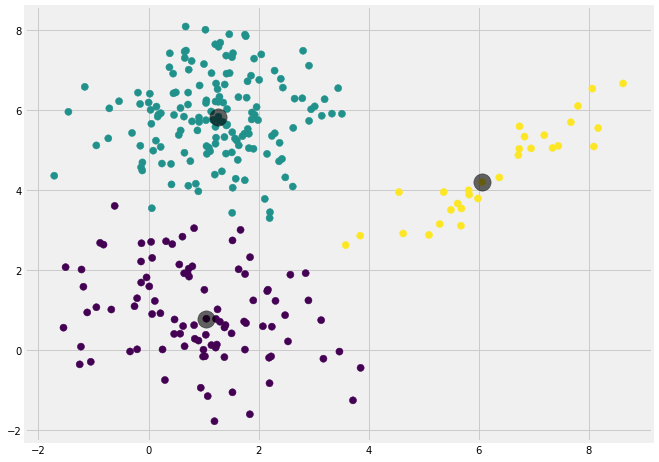

In [9]:
model = GMM(3, n_runs = 100)

fitted_values = model.fit(X)

predicted_values = model.predict(X)
# compute centers as point of highest density of distribution
centers = np.zeros((3,2))
for i in range(model.C):
    density = mvn(cov=model.sigma[i], mean=model.mu[i]).logpdf(X)
    centers[i, :] = X[np.argmax(density)]
    
plt.figure(figsize = (10,8))
plt.scatter(X[:, 0], X[:, 1],c=predicted_values ,s=50, cmap='viridis')

plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

# Compare sklearn and my own and test predict method

In [10]:
model.predict(X[5:10,:])
model.labels
# print("initial means: ", model._initial_means)
# print('--------------------------')
# print("initial pi: ", model._initial_pi)
# print('--------------------------')
# print('GMM means: ', model.get_params()[1])
# print('--------------------------')
# print('GMM pi: ', model.get_params()[0])
# print('--------------------------')
# print('sklearn GMM means: ', gmm._get_parameters()[1])
# print('--------------------------')
# print('sklearn GMM pi: ', gmm._get_parameters()[0])

AttributeError: 'GMM' object has no attribute 'labels'

# Plot clusters

In [11]:
# Credit to python data science handbook for the code to plot these distributions
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        

# Draw Distributions around GMM clusters

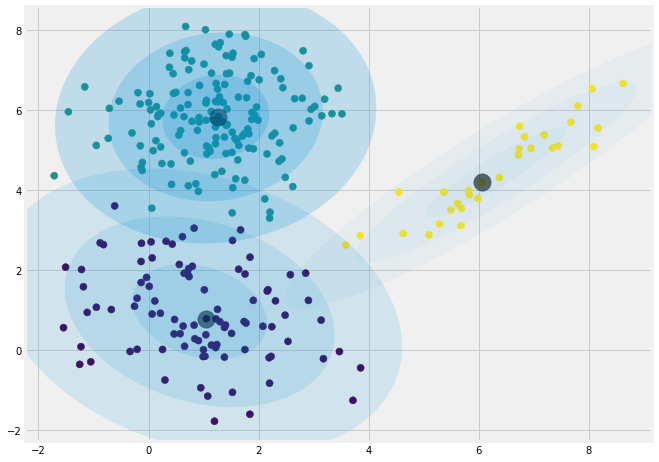

In [12]:
plt.figure(figsize = (10,8))
plt.scatter(X[:, 0], X[:, 1],c=predicted_values ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

w_factor = 0.2 / model.pi.max()
for pos, covar, w in zip(model.mu, model.sigma, model.pi):
    draw_ellipse(pos, covar, alpha=w * w_factor)

In [13]:
def E_step(X, pi, mu, sigma):
    """Performs E-step on GMM model

        Parameters:
        ------------
        X: (N x m), data points, m: no of features
        pi: (C), weights of mixture components
        mu: (C x m), mixture component means
        sigma: (C x m x m), mixture component covariance matrices

        Returns:
        ----------
        gamma: (N x C), probabilities of clusters for objects
        """
    
    N = X.shape[0] 
    C = pi0.shape[0] # number of clusters
    gamma = np.zeros((N, C))

    const_c = np.zeros(C)

    for c in range(C):
#         pi_c = pi0[c]
#         mu_c = mu0[c, :] 
#         sigma_c = sigma0[c] 

        # Posterior Distribution using Bayes Rule
        gamma[:,c] = pi0[c] * mvn.pdf(X, mu0[c,:], sigma0[c])

    # normalize across columns to make a valid probability
    gamma_norm = np.sum(gamma, axis=1)[:,np.newaxis]
    gamma /= gamma_norm

    return gamma

gamma = E_step(X, pi0, mu0, sigma0)
print(np.sum(gamma, axis=0))

[125.16650217 154.21348486   0.62001298]


# M Step

In [14]:
def M_step(X, gamma):
    """Performs M-step of the GMM
    We need to update our priors, our means
    and our covariance matrix.
    
    Parameters:
    -----------
    X: (N x d), data 
    gamma: (N x C), posterior distribution of lower bound 
    
    Returns:
    ---------
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    ### YOUR CODE HERE
    mu = np.zeros((C, d))
    sigma = np.zeros((C, d, d))
    
    # responsibilities for each gaussian
    pi = np.mean(gamma, axis = 0)
    mu = np.dot(gamma.T, X) / np.sum(gamma, axis = 0)[:,np.newaxis]
     
    for c in range(C): # for each Gaussian
        x_mu = X - mu[c, :] # (N x d)
        
        gamma_diag = np.diag(gamma[:,c])
        x_mu = np.matrix(x_mu)
        gamma_diag = np.matrix(gamma_diag)
        
        sigma_c = x_mu.T * gamma_diag * x_mu
        sigma[c,:,:]=(sigma_c) / np.sum(gamma, axis = 0)[:,np.newaxis][c]
    
    return pi, mu, sigma
pi, mu, sigma = M_step(X, gamma)
print(pi, mu, sigma)

[0.44702322 0.55076245 0.00221433] [[ 1.05852748  5.40759435]
 [ 2.16796132  2.89939188]
 [-1.33306197  1.41522785]] [[[ 0.70631457  1.00189734]
  [ 1.00189734  3.09525744]]

 [[ 5.76353448  1.49049001]
  [ 1.49049001  5.97710522]]

 [[ 0.0676037  -0.21186747]
  [-0.21186747  3.29922798]]]


# Variational Lower Bound
$$\mathcal{L} = \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] (\log \pi_k + \log \mathcal{N}(x_n | \mu_k, \sigma_k)) - \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] \log \mathbb{E}[z_{n, k}]$$

In [15]:
def compute_loss_function(X, gamma, pi, mu, sigma):
    N = X.shape[0]
    C = gamma.shape[1]
    loss = np.zeros((N,C))
    
    for c in range(C):
        dist = mvn(mu[c], sigma[c],allow_singular=True)
        loss[:,c] = gamma[:,c] * (np.log(pi[c]+0.00001)+dist.logpdf(X)-np.log(gamma[:,c]+0.000001))

    return np.sum(loss)

In [16]:
compute_loss_function(X, gamma, pi, mu, sigma)

-1213.9656095336381

# Test all functions
- seem to be correct. Class implmentation doesnt give same answer
- Could be because I have an incorrect initialisation

In [17]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_loss_function(X, gamma, pi, mu, sigma)

# Test on Enron data set

# Read in Data and Preprocess

In [18]:
df = pd.read_csv('../input/enron-email-dataset/emails.csv',nrows = 35000)

In [19]:
# create list of email objects
emails = list(map(email.parser.Parser().parsestr,df['message']))

# extract headings such as subject, from, to etc..
headings  = emails[0].keys()

# Goes through each email and grabs info for each key
# doc['From'] grabs who sent email in all emails
for key in headings:
    df[key] = [doc[key] for doc in emails]

    
##Useful functions
def get_raw_text(emails):
    email_text = []
    for email in emails.walk():
        if email.get_content_type() == 'text/plain':
            email_text.append(email.get_payload())
    return ''.join(email_text)

df['body'] = list(map(get_raw_text, emails))
df.head()
df['user'] = df['file'].map(lambda x: x.split('/')[0])


#Unique to and From
print('Total number of emails: %d' %len(df))
print('------------')
print('Number of unique received: %d '%df['To'].nunique())
print('------------')
print('Number of unique Sent: %d '%df['From'].nunique())


def clean_column(data):
    if data is not None:
        stopwords_list = stopwords.words('english')
        #exclusions = ['RE:', 'Re:', 're:']
        #exclusions = '|'.join(exclusions)
        data =  data.lower()
        data = re.sub('re:', '', data)
        data = re.sub('-', '', data)
        data = re.sub('_', '', data)
        # Remove data between square brackets
        data =re.sub('\[[^]]*\]', '', data)
        # removes punctuation
        data = re.sub(r'[^\w\s]','',data)
        data = re.sub(r'\n',' ',data)
        data = re.sub(r'[0-9]+','',data)
        # strip html 
        p = re.compile(r'<.*?>')
        data = re.sub(r"\'ve", " have ", data)
        data = re.sub(r"can't", "cannot ", data)
        data = re.sub(r"n't", " not ", data)
        data = re.sub(r"I'm", "I am", data)
        data = re.sub(r" m ", " am ", data)
        data = re.sub(r"\'re", " are ", data)
        data = re.sub(r"\'d", " would ", data)
        data = re.sub(r"\'ll", " will ", data)
        data = re.sub('forwarded by phillip k allenhouect on    pm', '',data)
        data = re.sub(r"httpitcappscorpenroncomsrrsauthemaillinkaspidpage", "", data)
        
        data = p.sub('', data)
        if 'forwarded by:' in data:
            data = data.split('subject')[1]
        data = data.strip()
        return data
    return 'No Subject'


df['Subject_new'] = df['Subject'].apply(clean_column)
df['body_new'] = df['body'].apply(clean_column)


from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
to_add = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa',
         'hou', 'cc', 'etc', 'subject', 'pm']

for i in to_add:
    stopwords.add(i)

Total number of emails: 35000
------------
Number of unique received: 4926 
------------
Number of unique Sent: 2151 


# TF-IDF

In [20]:
df['body_new'].head()

0                                 here is our forecast
1    traveling to have a business meeting takes the...
2                           test successful  way to go
3    randy   can you send me a schedule of the sala...
4                            lets shoot for tuesday at
Name: body_new, dtype: object

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
data = df['body_new']
# data.head()

tf_idf_vectorizor = TfidfVectorizer(stop_words = stopwords,#tokenizer = tokenize_and_stem,
                             max_features = 5000)
%time tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

/opt/conda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'fw', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 6.5 s, sys: 208 ms, total: 6.71 s
Wall time: 6.72 s


,aaron,abc,abcsubstringabclength,abel,abelhouectect,ability,able,absence,absolutely,ac,academy,accept,acceptable,acceptance,accepted,access,accessible,accessing,accommodate,accommodations,accomplish,accomplishments,according,accordingly,account,accounting,accounts,accrual,accuracy,accurate,accurately,achieve,acknowledge,acquire,acquired,acquiring,acquisition,acquisitions,across,act,...,writing,written,wrong,wrote,wrs,wti,wynn,xms,xp,ya,yahoo,yall,yard,yards,yea,yeah,year,yearend,yearold,years,yes,yesterday,yesterdays,yet,yo,york,youd,youll,young,youre,youve,ypc,yvette,zadow,zdnet,zero,zhiyong,zip,zipper,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100491,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# K means sklearn

CPU times: user 252 ms, sys: 288 ms, total: 540 ms
Wall time: 139 ms


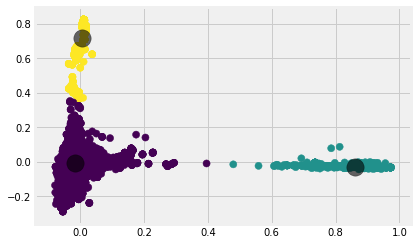

In [22]:
from sklearn.cluster import KMeans
n_clusters = 3
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= n_clusters, max_iter=600, algorithm = 'auto')
%time fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);

# Draw Distributions

In [23]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

# GMM sklearn

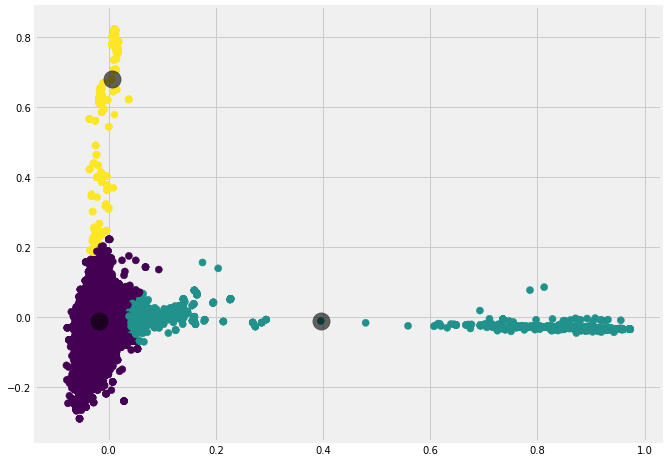

In [24]:
from sklearn.mixture import GaussianMixture
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(Y_sklearn)
prediction_gmm = gmm.predict(Y_sklearn)
probs = gmm.predict_proba(Y_sklearn)

centers = np.zeros((3,2))
for i in range(3):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

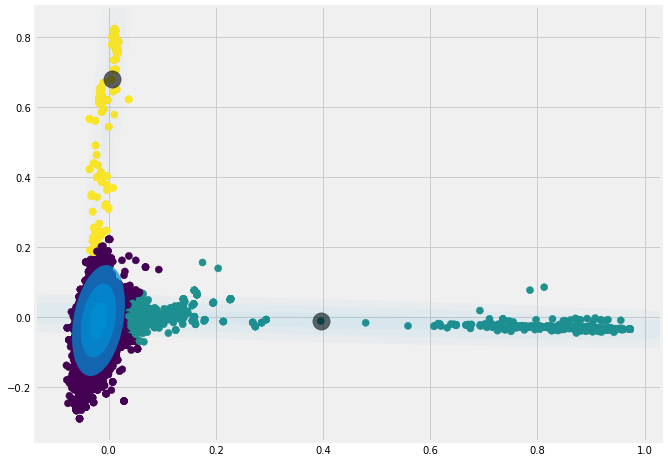

In [25]:
# diag, Gaussians are aligned with th axis
plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=50, cmap='viridis', zorder=1)
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

w_factor = 0.2 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w*.75)

In [26]:
print("GMM weights: ", gmm.weights_)
print("GMM means: ", gmm.means_)
print("GMM Covariance: ", gmm.covariances_)
print('-----------------------------')
print("My model weights: ", model.pi)
print("My model means: ", model.mu)
print("My model Covariance: ", model.sigma)

GMM weights:  [0.94459635 0.04184221 0.01356144]
GMM means:  [[-0.0189022  -0.00902179]
 [ 0.4260803  -0.01036099]
 [ 0.00197688  0.6603632 ]]
GMM Covariance:  [[[ 0.00027144  0.00025828]
  [ 0.00025828  0.00279929]]

 [[ 0.15959698 -0.00646384]
  [-0.00646384  0.00068936]]

 [[ 0.00025806  0.00239047]
  [ 0.00239047  0.03714139]]]
-----------------------------
My model weights:  [0.34212698 0.55138368 0.10648935]
My model means:  [[0.92998497 0.96464611]
 [1.22065268 5.82819177]
 [6.32030619 4.44860397]]
My model Covariance:  [[[ 1.50437117 -0.35522642]
  [-0.35522642  1.417763  ]]

 [[ 0.94791718  0.07196059]
  [ 0.07196059  1.10979245]]

 [[ 1.64334849  1.34344033]
  [ 1.34344033  1.28784027]]]


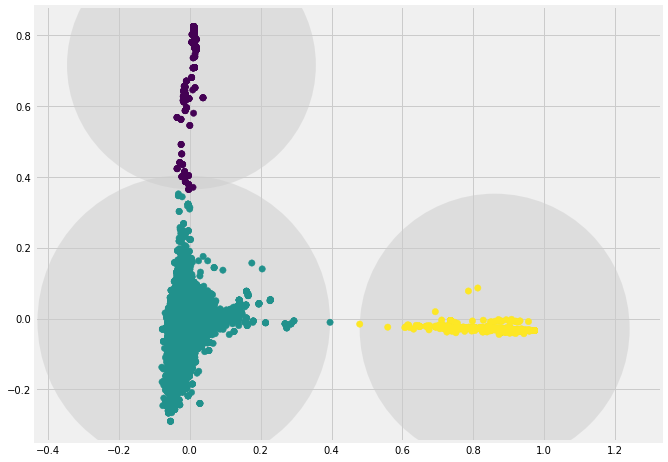

In [27]:
plt.figure(figsize = (10,8))
from scipy.spatial.distance import cdist
def plot_kmeans(kmeans, X, n_clusters=3, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
plot_kmeans(kmeans, Y_sklearn)

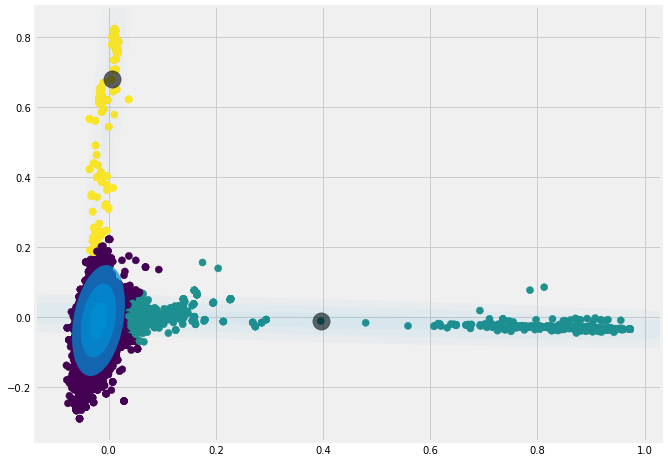

In [28]:
plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=50, cmap='viridis', zorder=1)
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

w_factor = 0.2 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w*.75)

# GMM my implementation

Iteration: 0 Loss: 125316.632051
Iteration: 10 Loss: 137122.518233
Iteration: 20 Loss: 137123.170472


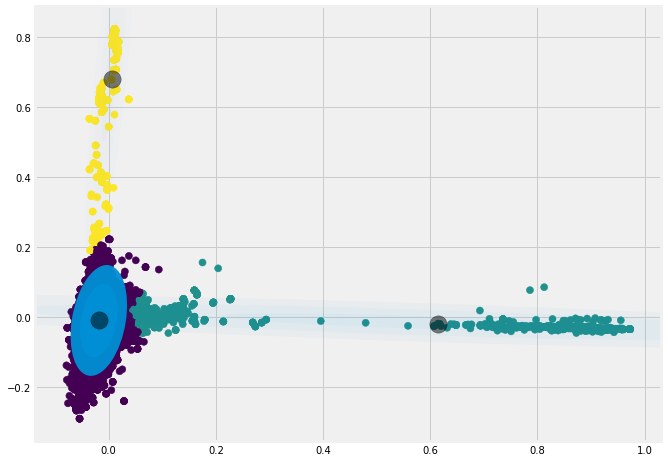

In [29]:
model = GMM(3, n_runs = 30)

fitted_values = model.fit(Y_sklearn)
predicted_values = model.predict(Y_sklearn)

# # compute centers as point of highest density of distribution
centers = np.zeros((3,2))
for i in range(model.C):
    density = mvn(cov=model.sigma[i], mean=model.mu[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]
    
plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=predicted_values ,s=50, cmap='viridis', zorder=1)

plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.5, zorder=2);

w_factor = 0.2 / model.pi.max()
for pos, covar, w in zip(model.mu, model.sigma, model.pi):
    draw_ellipse(pos, covar, alpha = w)